# Scaling collpase cleaned

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy.ma as ma
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
#from fssa import quality

In [2]:

# Python 2/3 compatibility
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import warnings
from builtins import *
from collections import namedtuple

import numpy as np
import numpy.ma as ma
import scipy.optimize


def _wls_linearfit_predict(x, w, wx, wy, wxx, wxy, select):
    """
    Predict a point according to a weighted least squares linear fit of the
    data
    This function is a helper function for :py:func:`quality`. It is not
    supposed to be called directly.
    Parameters
    ----------
    x : float
        The position for which to predict the function value
    w : ndarray
        The pre-calculated weights :math:`w_l`
    wx : ndarray
        The pre-calculated weighted `x` data :math:`w_l x_l`
    wy : ndarray
        The pre-calculated weighted `y` data :math:`w_l y_l`
    wxx : ndarray
    The pre-calculated weighted :math:`x^2` data :math:`w_l x_l^2`
    wxy : ndarray
        The pre-calculated weighted `x y` data :math:`w_l x_l y_l`
    select : indexing array
        To select the subset from the `w`, `wx`, `wy`, `wxx`, `wxy` data
    Returns
    -------
    float, float
        The estimated value of the master curve for the selected subset and the
        squared standard error
    """

    # linear fit
    k = w[select].sum()
    kx = wx[select].sum()
    ky = wy[select].sum()
    kxx = wxx[select].sum()
    kxy = wxy[select].sum()
    delta = k * kxx - kx ** 2
    m = 1. / delta * (k * kxy - kx * ky)
    b = 1. / delta * (kxx * ky - kx * kxy)
    b_var = kxx / delta
    m_var = k / delta
    bm_covar = - kx / delta

    # estimation
    y = b + m * x
    dy2 = b_var + 2 * bm_covar * x + m_var * x**2

    return y, dy2


def _jprimes(x, i, x_bounds=None):
    """
    Helper function to return the j' indices for the master curve fit
    This function is a helper function for :py:func:`quality`. It is not
    supposed to be called directly.
    Parameters
    ----------
    x : mapping to ndarrays
        The x values.
    i : int
        The row index (finite size index)
    x_bounds : 2-tuple, optional
        bounds on x values
    Returns
    -------
    ret : mapping to ndarrays
        Has the same keys and shape as `x`.
        Its element ``ret[i'][j]`` is the j' such that :math:`x_{i'j'} \leq
        x_{ij} < x_{i'(j'+1)}`.
        If no such j' exists, the element is np.nan.
        Convert the element to int to use as an index.
    """

    j_primes = - np.ones_like(x)

    try:
        x_masked = ma.masked_outside(x, x_bounds[0], x_bounds[1])
    except (TypeError, IndexError):
        x_masked = ma.asanyarray(x)

    k, n = x.shape

    # indices of lower and upper bounds
    edges = ma.notmasked_edges(x_masked, axis=1)
    x_lower = np.zeros(k, dtype=int)
    x_upper = np.zeros(k, dtype=int)
    x_lower[edges[0][0]] = edges[0][-1]
    x_upper[edges[-1][0]] = edges[-1][-1]

    for i_prime in range(k):
        if i_prime == i:
            j_primes[i_prime][:] = np.nan
            continue

        jprimes = np.searchsorted(
            x[i_prime], x[i], side='right'
        ).astype(float) - 1
        jprimes[
            np.logical_or(
                jprimes < x_lower[i_prime],
                jprimes >= x_upper[i_prime]
            )
        ] = np.nan
        j_primes[i_prime][:] = jprimes

    return j_primes


def _select_mask(j, j_primes):
    """
    Return a boolean mask for selecting the data subset according to the j'
    Parameters
    ----------
    j : int
        current j index
    j_primes : ndarray
        result from _jprimes call
    """

    ret = np.zeros_like(j_primes, dtype=bool)
    my_iprimes = np.invert(np.isnan(j_primes[:, j])).nonzero()[0]
    my_jprimes = j_primes[my_iprimes, j]
    my_jprimes = my_jprimes.astype(int)
    ret[my_iprimes, my_jprimes] = True
    ret[my_iprimes, my_jprimes + 1] = True

    return ret


def quality(x, y, dy, x_bounds=None):
    r'''
    Quality of data collapse onto a master curve defined by the data
    This is the reduced chi-square statistic for a data fit except that the
    master curve is fitted from the data itself.
    Parameters
    ----------
    x, y, dy : 2-D array_like
        output from :py:func:`scaledata`, scaled data `x`, `y` with standard
        errors `dy`
    x_bounds : tuple of floats, optional
        lower and upper bound for scaled data `x` to consider
    Returns
    -------
    float
        the quality of the data collapse
    Raises
    ------
    ValueError
        if not all arrays `x`, `y`, `dy` have dimension 2, or if not all arrays
        are of the same shape, or if `x` is not sorted along rows (``axis=1``),
        or if `dy` does not have only positive entries
    Notes
    -----
    This is the implementation of the reduced :math:`\chi^2` quality function
    :math:`S` by Houdayer & Hartmann [6]_.
    It should attain a minimum of around :math:`1` for an optimal fit, and be
    much larger otherwise.
    For further information, see the :ref:`quality-function` section in the
    manual.
    References
    ----------
    .. [6] J. Houdayer and A. Hartmann, Physical Review B 70, 014418+ (2004)
        `doi:10.1103/physrevb.70.014418
        <http://dx.doi.org/doi:10.1103/physrevb.70.014418>`_
    '''

    # arguments should be 2-D array_like
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    dy = np.asanyarray(dy)

    args = {"x": x, "y": y, "dy": dy}
    for arg_name, arg in args.items():
        if arg.ndim != 2:
            raise ValueError("{} should be 2-D array_like".format(arg_name))

    # arguments should have all the same shape
    if not x.shape == y.shape == dy.shape:
        raise ValueError("arguments should be of same shape")

    # x should be sorted for all system sizes l
    if not np.array_equal(x, np.sort(x, axis=1)):
        raise ValueError("x should be sorted for each system size")

    # dy should have only positive entries
    if not np.all(dy > 0.0):
        raise ValueError("dy should have only positive values")

    # first dimension: system sizes l
    # second dimension: parameter values rho
    k, n = x.shape

    # pre-calculate weights and other matrices
    w = dy ** (-2)
    wx = w * x
    wy = w * y
    wxx = w * x * x
    wxy = w * x * y

    # calculate master curve estimates
    master_y = np.zeros_like(y)
    master_y[:] = np.nan
    master_dy2 = np.zeros_like(dy)
    master_dy2[:] = np.nan

    # loop through system sizes
    for i in range(k):

        j_primes = _jprimes(x=x, i=i, x_bounds=x_bounds)

        # loop through x values
        for j in range(n):

            # discard x value if it is out of bounds
            try:
                if not x_bounds[0] <= x[i][j] <= x_bounds[1]:
                    continue
            except:
                pass

            # boolean mask for selected data x_l, y_l, dy_l
            select = _select_mask(j=j, j_primes=j_primes)

            if not select.any():
                # no data to select
                # master curve estimate Y_ij remains undefined
                continue

            # master curve estimate
            master_y[i, j], master_dy2[i, j] = _wls_linearfit_predict(
                x=x[i, j], w=w, wx=wx, wy=wy, wxx=wxx, wxy=wxy, select=select
            )

    # average within finite system sizes first
    return np.nanmean(
        np.nanmean(
            (y - master_y) ** 2 / (dy ** 2 + master_dy2),
            axis=1
        )
    )


def _neldermead_errors(sim, fsim, fun):
    """
    Estimate the errors from the final simplex of the Nelder--Mead algorithm
    This is a helper function and not supposed to be called directly.
    Parameters
    ----------
    sim : ndarray
        the final simplex
    fsim : ndarray
        the function values at the vertices of the final simplex
    fun : callable
        the goal function to minimize
    """

    # fit quadratic coefficients
    n = len(sim) - 1

    ymin = fsim[0]

    sim = np.copy(sim)
    fsim = np.copy(fsim)

    centroid = np.mean(sim, axis=0)
    fcentroid = fun(centroid)

    # enlarge distance of simplex vertices from centroid until all have at
    # least an absolute function value distance of 0.1
    for i in range(n + 1):
        while np.abs(fsim[i] - fcentroid) < 0.01:
            sim[i] += sim[i] - centroid
            fsim[i] = fun(sim[i])

    # the vertices and the midpoints x_ij
    x = 0.5 * (
        sim[np.mgrid[0:n + 1, 0:n + 1]][1] +
        sim[np.mgrid[0:n + 1, 0:n + 1]][0]
    )

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:n + 1, 0:n + 1]][0][1:, 1:, 0]

    y0j = y[np.mgrid[0:n + 1, 0:n + 1]][0][0, 1:, 1:]

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)

    q = (sim - sim[0])[1:].T

    varco = ymin * np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco)), varco

In [14]:
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    R2 = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID'] for i in range(len(Ws))])
            R2[seed] = np.array([data[i]['rsquared'] for i in range(len(Ws))])
            
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID, R2

def x_func(rho, rho_c, l, nu):
    return np.power(l, 1./nu) * (rho-rho_c)

def x_BKT(rho, rho_c, l, alpha):
    return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))

def y_func(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y

def goal_function(args = [3.,2.2,1.2, 1.4]):#, bounds=[(3.1,3.9),(1.,3.),(1.,3.),(0.,3.)]):
    ''' rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]'''
    rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]
    
    x,y,dy = scaledata(l,rho,a,da,rho_c,nu,zeta, alpha)
    
    '''
    i = rho_c
    
    if i < bounds[0][0]:
        return quality(x,y,dy) * (1+ abs(bounds[0][0]-i))*2
        
    elif i > bounds[0][1]:
        return quality(x,y,dy) * (1+abs(i-bounds[0][1]))*2
    else:
    '''
    return quality(x,y,dy)
                
                
    
    
def scaledata(l, rho, a, da, rho_c, nu, zeta, alpha):
    # rho_c, nu, and zeta should be float
    rho_c = float(rho_c)
    nu = float(nu)
    zeta = float(zeta)   

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    
    '''x = np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c) ## old'''
    x = x_BKT(rho_mesh, rho_c,l_mesh,alpha)
    y = np.power(l_mesh, - zeta / nu) * a
    dy = np.power(l_mesh, - zeta / nu) * da

    sorting_index = np.argsort(x)[0]
    
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]

    return x, y, dy

def autoscale(l, rho, a, da, rho_c0, nu0, zeta0, alpha0, bnds=None, **kwargs):
    

    ret = minimize(
        goal_function,
        [rho_c0, nu0, zeta0,alpha0],
        method='nelder-mead',
        bounds= bnds,
        options={
            'xatol': 1e-2,
            'fatol': 1e-2,
            
        })
    
    errors, varco = _neldermead_errors(
        sim=ret['final_simplex'][0],
        fsim=ret['final_simplex'][1],
        fun=goal_function,
    )
    varco

    ret['varco'] = varco
    ret['errors'] = errors
    ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
    ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']
    
    
    return ret

def _neldermead_errors(sim, fsim, fun):
    """
    Estimate the errors from the final simplex of the Nelder--Mead algorithm
    This is a helper function and not supposed to be called directly.
    Parameters
    ----------
    sim : ndarray
        the final simplex
    fsim : ndarray
        the function values at the vertices of the final simplex
    fun : callable
        the goal function to minimize
    """

    # fit quadratic coefficients
    n = len(sim) - 1

    ymin = fsim[0]

    sim = np.copy(sim)
    fsim = np.copy(fsim)

    centroid = np.mean(sim, axis=0)
    fcentroid = fun(centroid)

    # enlarge distance of simplex vertices from centroid until all have at
    # least an absolute function value distance of 0.1
    for i in range(n + 1):
        while np.abs(fsim[i] - fcentroid) < 0.01:
            sim[i] += sim[i] - centroid
            fsim[i] = fun(sim[i])

    # the vertices and the midpoints x_ij
    x = 0.5 * (
        sim[np.mgrid[0:n + 1, 0:n + 1]][1] +
        sim[np.mgrid[0:n + 1, 0:n + 1]][0]
    )

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:n + 1, 0:n + 1]][0][1:, 1:, 0]

    y0j = y[np.mgrid[0:n + 1, 0:n + 1]][0][0, 1:, 1:]

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)

    q = (sim - sim[0])[1:].T

    varco = ymin * np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco)), varco


In [15]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

ID8, R2_8 = load_IDs(8, range(0,100000))
ID10, R2_10 = load_IDs(10, range(0,10000))
ID12, R2_12 = load_IDs(12, range(0,5000))
ID14, R2_14 = load_IDs(14, range(0,1000))

Loaded 100000 out of 100000 seeds
Loaded 10000 out of 10000 seeds
Loaded 5000 out of 5000 seeds
Loaded 1000 out of 1000 seeds


In [16]:
l = [8,10,12,14]
rho = Ws
a = np.vstack([ma.average(ID, axis=0, weights=R2) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

da = np.vstack([np.array([np.sqrt(np.cov(ID14[:,W], 
                aweights=R2_14[:,W])) for W in range(len(Ws))]) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

start,stop = 8,47
a_full, da_full, rho_full = a.copy(), da.copy(), rho.copy()
a, da, rho = a[:,start:stop],da[:,start:stop],rho[start:stop]
rho

array([2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 ,
       3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65,
       3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 ,
       4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ])

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 57.66it/s]


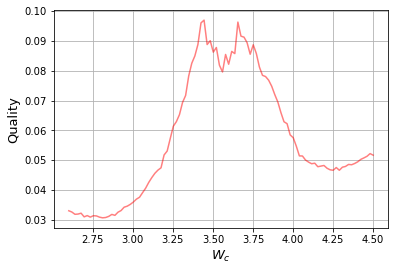

In [17]:
out = []
rs = np.linspace(min(rho),max(rho),100)
for r in tqdm(rs):
    out.append(goal_function([r,1.65,2.17,1.53]))
plt.plot(rs,out, c='r', alpha=.5)
plt.xlabel('$W_c$', fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.grid()
plt.show()


In [19]:
ret = autoscale(l, rho, a, da, 3.55,1.6,1.9, 1.4, bnds=[(3.4,3.75),(1.,3.),(1.,3.),(0.,3.)])
ret['errors'] = np.sqrt(np.diag(abs(ret['varco'])))
ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']
ret

ValueError: output array is read-only

In [ ]:
x, y, dy = scaledata(l, rho, a, da, ret['rho'], ret['nu'], ret['zeta'], ret['alpha'])

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(14,5))

for i,j,k in zip(np.vstack([rho_full,rho_full,rho_full,rho_full]),a_full,da_full):
    ax[0].errorbar(i,j, yerr=k)    

for i,j,k in zip(np.vstack([rho,rho,rho,rho]),a,da):
    ax[1].errorbar(i,j, yerr=k)    

for i,j,k in zip(x,y,dy):
    ax[2].errorbar(i,j, yerr=k, lw=.3)
    ax[2].plot(i,j)
#ax[1].set_xlim(0,100)